In [ ]:
!pip install torchsummaryX # We also install a summary package to check our model's forward before training

In [ ]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation
from tqdm import tqdm
from torchsummaryX import summary


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
dataset = np.load('dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('dataset/wiki.valid.npy', allow_pickle=True)
# fixtures_pred = np.load('fixtures/prediction.npz')  # dev
# fixtures_gen = np.load('fixtures/generation.npy')  # dev
# fixtures_pred_test = np.load('fixtures/prediction_test.npz')  # test
# fixtures_gen_test = np.load('fixtures/generation_test.npy')  # test
vocab = np.load('dataset/vocab.npy')

In [ ]:
# fixtures_pred['inp'][1].shape

In [ ]:
vocab.shape
dataset.shape

(579,)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data loader

class LanguageModelDataLoader(DataLoader):

    def __init__(self, dataset, batch_size, shuffle=True, seq_len=3):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seq_len = seq_len
        
        # if self.shuffle:
        #     np.random.shuffle(self.dataset)
        # self.dataset = np.concatenate(self.dataset)
    
    def __len__(self) -> int:
        return len(self.dataset) // ((self.seq_len + 1) * self.batch_size)


    def __iter__(self):

        for i in range(0, len(self.dataset), (self.seq_len + 1) * self.batch_size):
            input = []
            label = []
            for b in range(self.batch_size):
                idx = i + b*(self.seq_len + 1)

                input_1 = self.dataset[idx:idx+self.seq_len]
                label_1 = self.dataset[idx+1:idx+1+self.seq_len]
                # print(input_1.shape)
                if len(input_1) == len(label_1) == self.seq_len:
                    input.append(input_1)
                    label.append(label_1)
                    
            input = torch.LongTensor(input)
            label = torch.LongTensor(label)
            
            if input.size(dim=0) != 0:
                yield (input, label)
        
        

In [ ]:
train_loader = LanguageModelDataLoader(dataset=dataset, batch_size=3, seq_len=10)
for i, l in train_loader:
    print(i.size(), l.size())
    break


torch.Size([3, 10]) torch.Size([3, 10])


In [ ]:
# model

class LanguageModel(nn.Module):

    def __init__(self, vocab_size, seq_len):
        super(LanguageModel, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, 256)
        self.lstm = nn.LSTM(input_size=256, hidden_size=512, num_layers=3, batch_first=True)
        self.linear1 = nn.Linear(in_features=512, out_features=256)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(in_features=256, out_features=vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        self.emb.weight = self.linear2.weight

    def forward(self, x):
        # print(x.size())
        out = self.emb(x)
        # print(out.size())
        out, _ = self.lstm(out)
        # print(out.size())
        out = self.linear1(out)
        out = self.act(out)
        out = self.dropout(out)
        out = self.linear2(out)

        # print(out.size())
        out = self.logsoftmax(out)
        
        return out

    


In [ ]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):

        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 2e-3, weight_decay=1e-4)
        self.criterion = nn.CrossEntropyLoss()
        # self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=2, factor=0.8)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=(len(self.loader) * 10))


    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += float(self.train_batch(inputs, targets))
            batch_bar.set_postfix(
                loss="{:.04f}".format(float(epoch_loss / (batch_num + 1))),
                lr="{:.04f}".format(float(self.optimizer.param_groups[0]['lr']))
            )
            batch_bar.update()
        batch_bar.close()
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):

        self.optimizer.zero_grad()
        inputs = inputs.long().to(self.device)
        targets = targets.long().to(self.device)

        outputs = self.model(inputs)

        loss = self.criterion(torch.transpose(outputs, 1, 2), targets)

        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        return float(loss)

    
    def test(self):
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll

    def save(self):
        model_path = os.path.join('/content/drive/My Drive/experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        # np.save(os.path.join('/content/drive/My Drive/experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        # np.save(os.path.join('/content/drive/My Drive/experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        # np.save(os.path.join('/content/drive/My Drive/experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        # np.save(os.path.join('/content/drive/My Drive/experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        # with open(os.path.join('/content/drive/My Drive/experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
        #     fw.write(self.generated[-1])
        # with open(os.path.join('/content/drive/My Drive/experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
        #     fw.write(self.generated_test[-1])


In [ ]:
class TestLanguageModel:
    def prediction(inp, model):

        inp = torch.LongTensor(inp).to(device)
        with torch.no_grad():
            output = model(inp)
            # print(output.size())
        scores = output[:, -1, :].cpu().numpy()
        # print(scores.shape)
        return scores
        
        
    def generation(inp, forward, model):
      
        generated_output = []
        for i in range(forward):
            output = TestLanguageModel.prediction(inp, model)
            output_pred = np.argmax(output, axis=1).reshape((-1,1))
            
            if output_pred[0][0] == 1419:
                indices = np.argsort(output, axis=1)[::-1]
                # print(indices)
                output_pred = indices[:, 1].reshape((-1,1))
            # print(output_pred)

            generated_output.append(output_pred)

            inp = inp[:, 1:]
            inp = np.concatenate([inp, output_pred], axis=1)
        generated_output = np.concatenate(generated_output, axis=1)
        return generated_output

        

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
SEQ_LEN = 8

In [ ]:
run_id = str(int(time.time()))
if not os.path.exists('/content/drive/My Drive/experiments'):
    os.mkdir('/content/drive/My Drive/experiments')
os.mkdir('/content/drive/My Drive/experiments/%s' % run_id)
print("Saving models, predictions, and generated words to /content/drive/My Drive/experiments/%s" % run_id)

Saving models, predictions, and generated words to /content/drive/My Drive/experiments/1653254080


In [ ]:
model = LanguageModel(len(vocab), SEQ_LEN)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, seq_len=SEQ_LEN)
for x, lx in loader:
    print(x.size(), lx.size())
    break
summary(model, x)
model = model.to(device)
# print(len(loader))
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)


torch.Size([100, 8]) torch.Size([100, 8])
              Kernel Shape     Output Shape     Params  Mult-Adds
Layer                                                            
0_emb         [256, 33278]    [100, 8, 256]  8.519168M  8.519168M
1_lstm                   -    [100, 8, 512]  5.779456M  5.767168M
2_linear1       [512, 256]    [100, 8, 256]   131.328k   131.072k
3_act                    -    [100, 8, 256]          -          -
4_dropout                -    [100, 8, 256]          -          -
5_linear2     [256, 33278]  [100, 8, 33278]  8.552446M  8.519168M
6_logsoftmax             -  [100, 8, 33278]          -          -
-----------------------------------------------------------------
                          Totals
Total params          22.982398M
Trainable params      22.982398M
Non-trainable params         0.0
Mult-Adds             22.936576M


/usr/local/lib/python3.7/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


In [ ]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    # nll = trainer.test()
    # trainer.scheduler.step(nll)

    # if nll < best_nll:
    #     best_nll = nll
    #     print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
    trainer.save()
    

[TRAIN]  Epoch [1/100]   Loss: 8.9420


[TRAIN]  Epoch [2/100]   Loss: 8.5308


[TRAIN]  Epoch [3/100]   Loss: 8.3838


[TRAIN]  Epoch [4/100]   Loss: 8.2829


[TRAIN]  Epoch [5/100]   Loss: 8.1619


[TRAIN]  Epoch [6/100]   Loss: 8.0664


[TRAIN]  Epoch [7/100]   Loss: 7.9898


[TRAIN]  Epoch [8/100]   Loss: 7.9509


[TRAIN]  Epoch [9/100]   Loss: 7.8520


[TRAIN]  Epoch [10/100]   Loss: 7.8432


[TRAIN]  Epoch [11/100]   Loss: 7.8425


[TRAIN]  Epoch [12/100]   Loss: 7.8300


[TRAIN]  Epoch [13/100]   Loss: 7.7982


[TRAIN]  Epoch [14/100]   Loss: 7.7349


[TRAIN]  Epoch [15/100]   Loss: 7.7092


[TRAIN]  Epoch [16/100]   Loss: 7.8080


[TRAIN]  Epoch [17/100]   Loss: 7.8092


[TRAIN]  Epoch [18/100]   Loss: 7.7307


[TRAIN]  Epoch [19/100]   Loss: 7.6570


[TRAIN]  Epoch [20/100]   Loss: 7.5157


[TRAIN]  Epoch [21/100]   Loss: 7.4493


[TRAIN]  Epoch [22/100]   Loss: 7.3378


[TRAIN]  Epoch [23/100]   Loss: 7.2359


[TRAIN]  Epoch [24/100]   Loss: 7.0769


[TRAIN]  Epoch [25/100]   Loss: 6.8578


[TRAIN]  Epoch [26/100]   Loss: 6.6557


[TRAIN]  Epoch [27/100]   Loss: 6.4619


[TRAIN]  Epoch [28/100]   Loss: 6.3638


[TRAIN]  Epoch [29/100]   Loss: 6.3474


[TRAIN]  Epoch [30/100]   Loss: 6.3433


[TRAIN]  Epoch [31/100]   Loss: 6.3304


[TRAIN]  Epoch [32/100]   Loss: 6.2919


[TRAIN]  Epoch [33/100]   Loss: 6.2302


[TRAIN]  Epoch [34/100]   Loss: 6.1775


[TRAIN]  Epoch [35/100]   Loss: 6.2369


[TRAIN]  Epoch [36/100]   Loss: 6.4155


[TRAIN]  Epoch [37/100]   Loss: 6.4877


[TRAIN]  Epoch [38/100]   Loss: 6.5074


[TRAIN]  Epoch [39/100]   Loss: 6.4002


[TRAIN]  Epoch [40/100]   Loss: 6.1808


[TRAIN]  Epoch [41/100]   Loss: 5.9077


[TRAIN]  Epoch [42/100]   Loss: 5.7330


[TRAIN]  Epoch [43/100]   Loss: 5.5175


[TRAIN]  Epoch [44/100]   Loss: 5.2534


[TRAIN]  Epoch [45/100]   Loss: 4.9013


[TRAIN]  Epoch [46/100]   Loss: 4.5966


[TRAIN]  Epoch [47/100]   Loss: 4.4536


[TRAIN]  Epoch [48/100]   Loss: 4.4299


[TRAIN]  Epoch [49/100]   Loss: 4.4370


[TRAIN]  Epoch [50/100]   Loss: 4.4330


[TRAIN]  Epoch [51/100]   Loss: 4.3993


[TRAIN]  Epoch [52/100]   Loss: 4.3786


[TRAIN]  Epoch [53/100]   Loss: 4.3320


[TRAIN]  Epoch [54/100]   Loss: 4.3432


[TRAIN]  Epoch [55/100]   Loss: 4.5560


[TRAIN]  Epoch [56/100]   Loss: 4.8084


[TRAIN]  Epoch [57/100]   Loss: 4.7623


[TRAIN]  Epoch [58/100]   Loss: 4.6854


[TRAIN]  Epoch [59/100]   Loss: 4.6768


[TRAIN]  Epoch [60/100]   Loss: 4.5329


[TRAIN]  Epoch [61/100]   Loss: 4.2691


[TRAIN]  Epoch [62/100]   Loss: 3.9969


[TRAIN]  Epoch [63/100]   Loss: 3.9297


[TRAIN]  Epoch [64/100]   Loss: 3.5136


[TRAIN]  Epoch [65/100]   Loss: 3.0414


[TRAIN]  Epoch [66/100]   Loss: 2.8817


[TRAIN]  Epoch [67/100]   Loss: 2.8530


[TRAIN]  Epoch [68/100]   Loss: 2.8523


[TRAIN]  Epoch [69/100]   Loss: 2.8442


[TRAIN]  Epoch [70/100]   Loss: 2.8156


[TRAIN]  Epoch [71/100]   Loss: 2.7738


[TRAIN]  Epoch [72/100]   Loss: 2.7478


[TRAIN]  Epoch [73/100]   Loss: 2.7251


[TRAIN]  Epoch [74/100]   Loss: 2.8022


[TRAIN]  Epoch [75/100]   Loss: 2.9277


[TRAIN]  Epoch [76/100]   Loss: 3.1284


[TRAIN]  Epoch [77/100]   Loss: 3.4260


[TRAIN]  Epoch [78/100]   Loss: 3.3286


[TRAIN]  Epoch [79/100]   Loss: 3.1040


[TRAIN]  Epoch [80/100]   Loss: 2.9393


[TRAIN]  Epoch [81/100]   Loss: 2.7395


[TRAIN]  Epoch [82/100]   Loss: 2.4707


[TRAIN]  Epoch [83/100]   Loss: 2.1850


[TRAIN]  Epoch [84/100]   Loss: 1.8214


[TRAIN]  Epoch [85/100]   Loss: 1.7103


[TRAIN]  Epoch [86/100]   Loss: 1.7014


[TRAIN]  Epoch [87/100]   Loss: 1.6975


[TRAIN]  Epoch [88/100]   Loss: 1.6816


[TRAIN]  Epoch [89/100]   Loss: 1.6730


[TRAIN]  Epoch [90/100]   Loss: 1.6606


[TRAIN]  Epoch [91/100]   Loss: 1.6470


[TRAIN]  Epoch [92/100]   Loss: 1.6625


[TRAIN]  Epoch [93/100]   Loss: 1.7034


[TRAIN]  Epoch [94/100]   Loss: 1.7782


[TRAIN]  Epoch [95/100]   Loss: 1.8861


[TRAIN]  Epoch [96/100]   Loss: 2.0636


[TRAIN]  Epoch [97/100]   Loss: 2.1455


[TRAIN]  Epoch [98/100]   Loss: 2.0895


[TRAIN]  Epoch [99/100]   Loss: 1.9396


[TRAIN]  Epoch [100/100]   Loss: 1.9279


<class 'numpy.ndarray'> <class 'list'>


ValueError: ignored

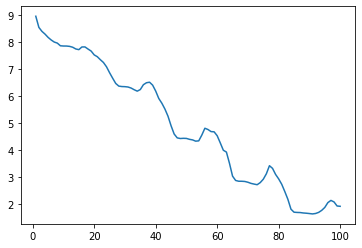

In [ ]:

plt.figure()
a = np.arange(1, trainer.epochs + 1)
b = trainer.train_losses
print(type(a), type(b))
plt.plot(a, b, label='Training losses')
plt.plot(np.arange(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [ ]:
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the first time , and the first single was released
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> The film 's first single ,
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single , and the film 's " <unk> " .
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and the <unk> <unk> . <eol> = = = <unk>
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | . <eol> = = = <unk> = = = <eol>
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | , and the <unk> <unk> . <eol> = = =
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heav

In [ ]:
# !make runid=1651104403 epoch=10

cp experiments/1651104403/predictions-test-10.npy predictions.npy
cp experiments/1651104403/generated-10.txt generated.txt
cp experiments/1651104403/generated_logits-test-10.npy generated_logits.npy


In [ ]:
# !ls

dataset      fixtures		   generated.txt  predictions.npy  sample_data
experiments  generated_logits.npy  Makefile	  __pycache__	   tests_hw4.py


# Inference

In [ ]:
model_path = '/content/drive/My Drive/experiments/1653178725/model-11.pkl'

In [ ]:
model.load_state_dict(torch.load(model_path)['state_dict'])
model.eval()
print(model)

LanguageModel(
  (emb): Embedding(33278, 256)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=256, out_features=33278, bias=True)
  (logsoftmax): LogSoftmax(dim=2)
)


In [ ]:
input_string = "i am going to"

In [ ]:
def array_to_str(arr, vocab):
    return " ".join(vocab[a] for a in arr)

def str_to_array(s, vocab):
    words = s.split()
    arr = []
    for w in words:
        print(w)
        arr.append(np.where(vocab==w)[0][0])
    # arr = [np.where(vocab==w)[0][0] for w in words]
    return np.array(arr)

In [ ]:
vocab = np.load('dataset/vocab.npy')
np.where(vocab=='1')[0][0]

117

In [ ]:
inp_arr = str_to_array(input_string.lower(), vocab)
prediction = TestLanguageModel.generation(inp_arr.reshape(1, -1), 1, model)
print(prediction)

i
am
going
to
[[16134 14658 22200    73    79  1417  1420  1420  1420  1420]]


In [ ]:
array_to_str(prediction[0], vocab)

'be a h ) . <eol> = = = ='